Le dataset que nous utilisons dans cette analyse concerne un ensemble de données de la NASA obtenu à partir d’une série d’essais aérodynamiques et acoustiques de sections de pales bidimensionnelles et tridimensionnelles menées dans une soufflerie anéchoïque.
<br>
<br>
**Statistiques de base :**
* Nombre de lignes : 1503
* Nombre de colonnes : 6
* Valeurs manquantes : 0
<br>
<br>

**Objectif de l'analyse :**
<br>
Notre objectif principal est de développer un modèle de prédiction pour le niveau de pression acoustique mis à l'échelle en décibels. Pour cela nous allons utiliser une technique de régression.
<br>
<br>

**Sources utilisées :**
<br>

# **Imports <br> Initialisation des variables**

In [7]:
# pip install scikit-learn, xgboost, catboost, lightgbm, matplotlib, numpy, pandas, seaborn, MiniSom, scikit-optimize
from sklearn.ensemble import (BaggingRegressor,
                              ExtraTreesRegressor,
                              RandomForestRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (mean_absolute_error as MAE,
                             mean_squared_error as MSE,
                             r2_score)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from skopt import BayesSearchCV

from xgboost import XGBRegressor
# !pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lime import lime_tabular

import matplotlib.pyplot as plt

# pip install numpy==1.23.5
import numpy as np
# print(np.__version__)

import pandas as pd
import seaborn as sns
import shap

# !pip install MiniSom
from minisom import MiniSom

data = pd.read_csv(r'C:\Users\godai\Documents\BUT\semestre_5\Données massives\Prediction_pression_accoustique\AirfoilSelfNoise.csv')


# **Renommage des colonnes**

In [8]:
data = data.rename(columns={'f': 'fq_hertz',
                            'alpha': 'angle_attaque',
                            'c': 'longueur_corde',
                            'U_infinity': 'vitesse_flux_libre',
                            'delta': 'epaisseur_dep_aspiration',
                            'SSPL': 'pression_accoustique'})
display(data.head(2))

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201


# **Apperçu du dataset**

In [20]:
# apperçu des données*
print("\tDIMENSIONS DU DATA (lignes, colonnes) :", data.shape)
print("\n\n\tPREMIERES LIGNES")
display(data.head(3))
print("\n\n\tINFORMATIONS SUR LE DATA")
print(data.info(), "\n\n")

	DIMENSIONS DU DATA (lignes, colonnes) : (1503, 6)


	PREMIERES LIGNES


,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951




	INFORMATIONS SUR LE DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fq_hertz                  1503 non-null   int64  
 1   angle_attaque             1503 non-null   float64
 2   longueur_corde            1503 non-null   float64
 3   vitesse_flux_libre        1503 non-null   float64
 4   epaisseur_dep_aspiration  1503 non-null   float64
 5   pression_accoustique      1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
None 




# **Nettoyage et statistiques récapitulatives du dataset**

In [4]:
# affichage des données nulles
display(data.isnull().sum())

data = data.dropna() # supprimer les lignes qui contiennent des valeurs manquantes
data = data.drop_duplicates() # supprimer les doublons

fq_hertz                    0
angle_attaque               0
longueur_corde              0
vitesse_flux_libre          0
epaisseur_dep_aspiration    0
pression_accoustique        0
dtype: int64

## Remarque
Pas de valeurs manquantes

In [5]:
display(data.describe())

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


## Remarques
On remarque des valeurs aberrantes dans la première et la deuxième colonnes car le maximum est très éloigné du 3e quartile.

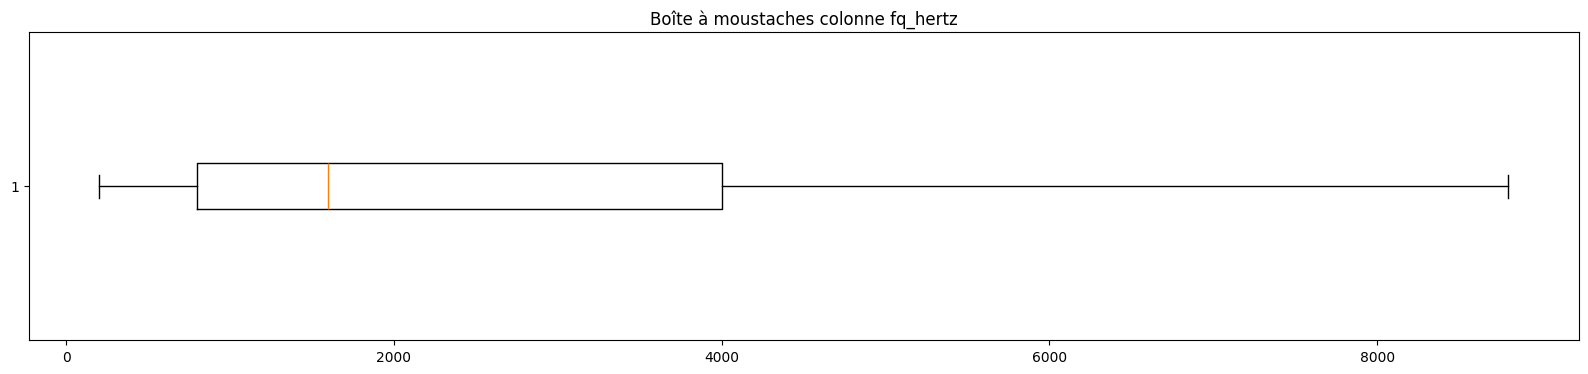

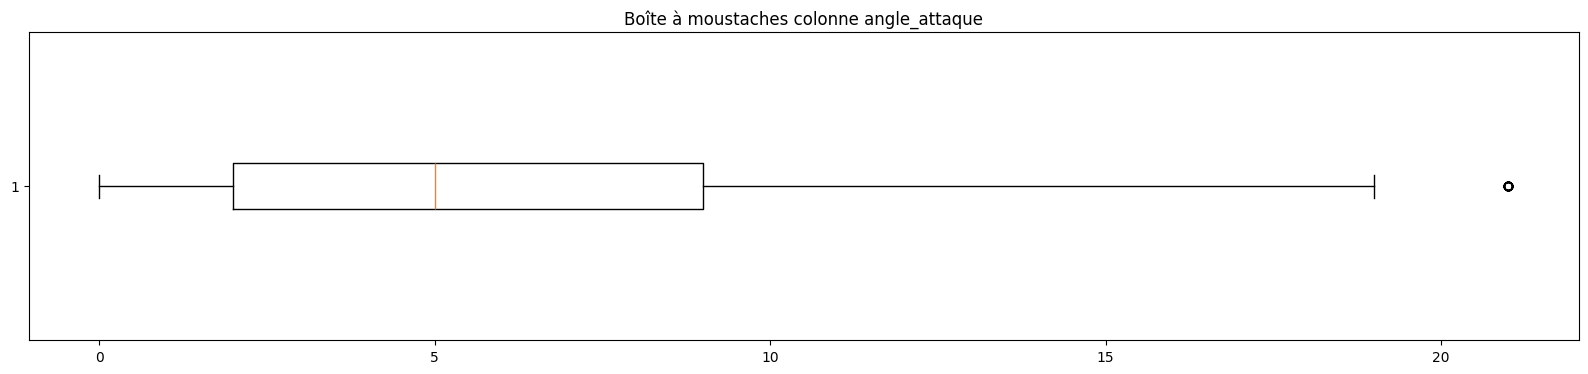

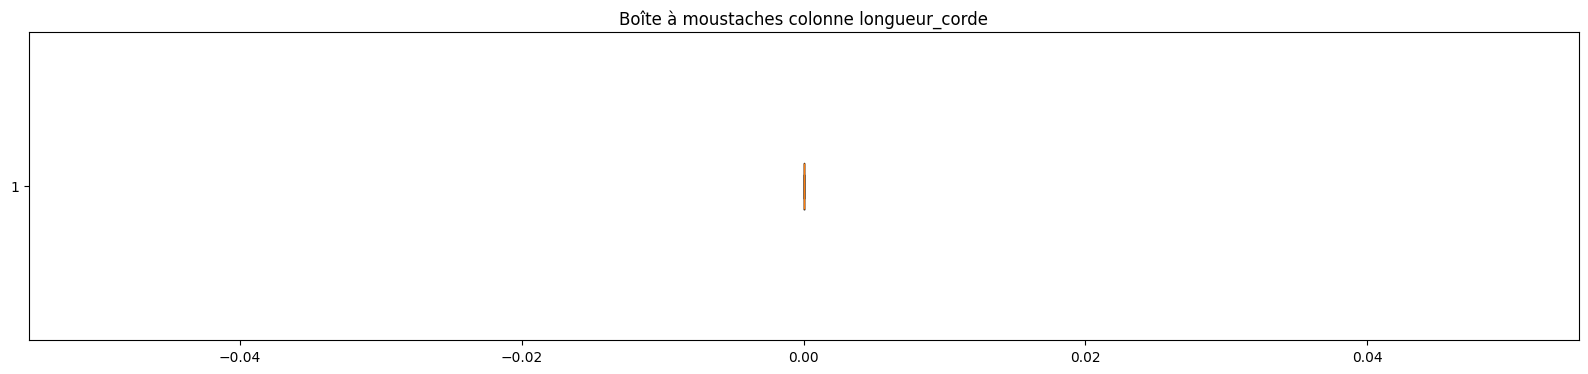

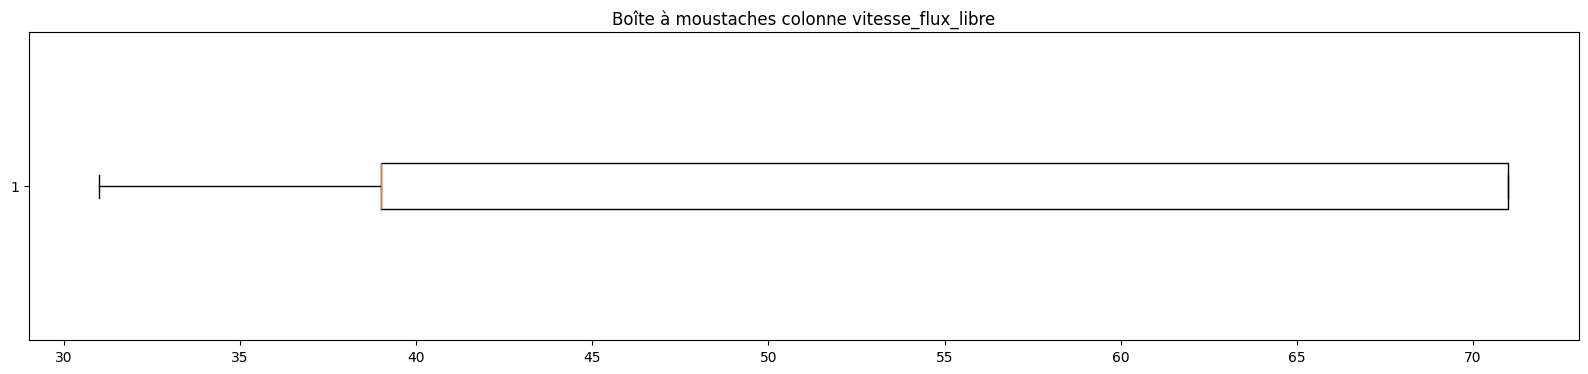

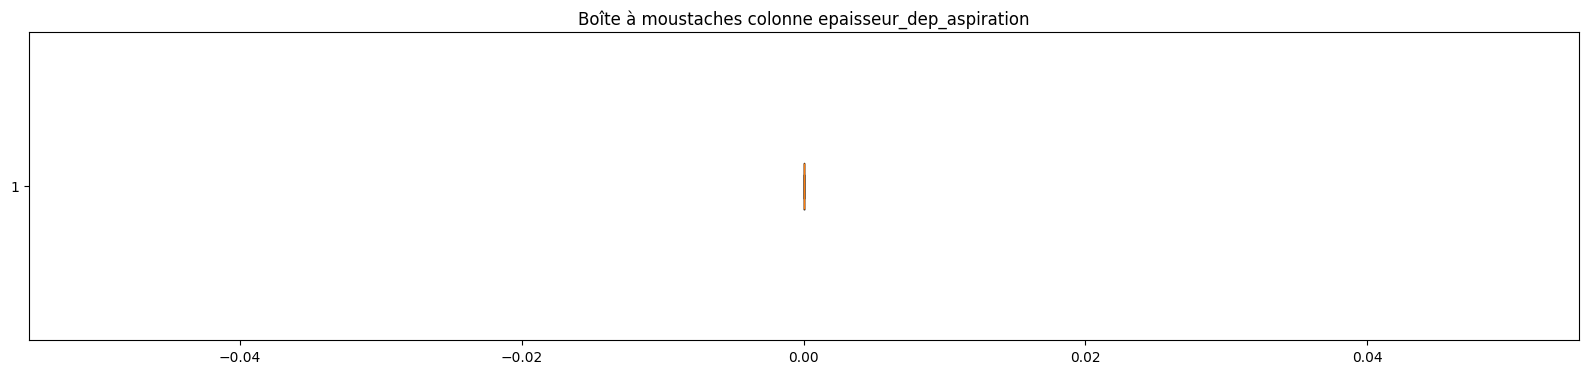

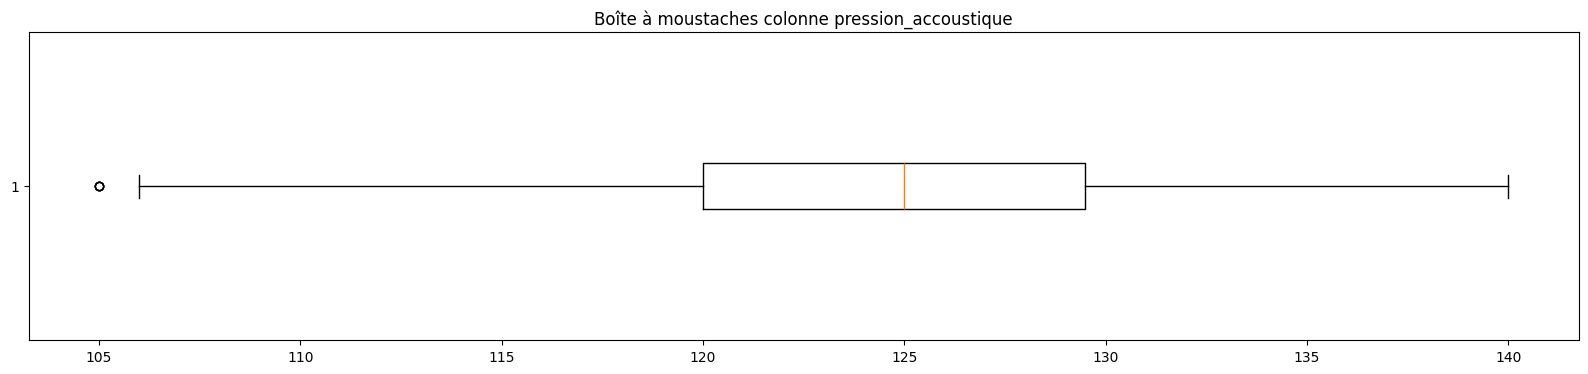

In [7]:
def remplacer_valeurs_aberrantes(data, column):
  valeurs = data[column].astype(float)

  # Calcul des quartiles
  q1 = valeurs.quantile(0.25)
  q3 = valeurs.quantile(0.75)

  # Calcul de la plage interquartiles
  iqr = q3 - q1

  # Calcul des limites des moustaches
  moustache_inferieure = q1 - 1.5 * iqr
  moustache_superieure = q3 + 1.5 * iqr

  # Remplacement des valeurs aberrantes par des valeurs entre le premier et le troisième quartile
  data.loc[data[column] < moustache_inferieure, column] = moustache_inferieure
  data.loc[data[column] > moustache_superieure, column] = moustache_superieure


def affichage_box_plot(column):
  valeurs = data[column].astype(int).tolist()
  plt.figure(figsize=(20, 4))
  plt.boxplot(valeurs, vert=False)
  plt.title(f'Boîte à moustaches colonne {column}')
  plt.show()

for column in data.columns:
    # remplacer_valeurs_aberrantes(data, column)
    affichage_box_plot(column)

# **=========================================================================================Exploratory_Data_Analysis_(EDA)=========================================================================================**

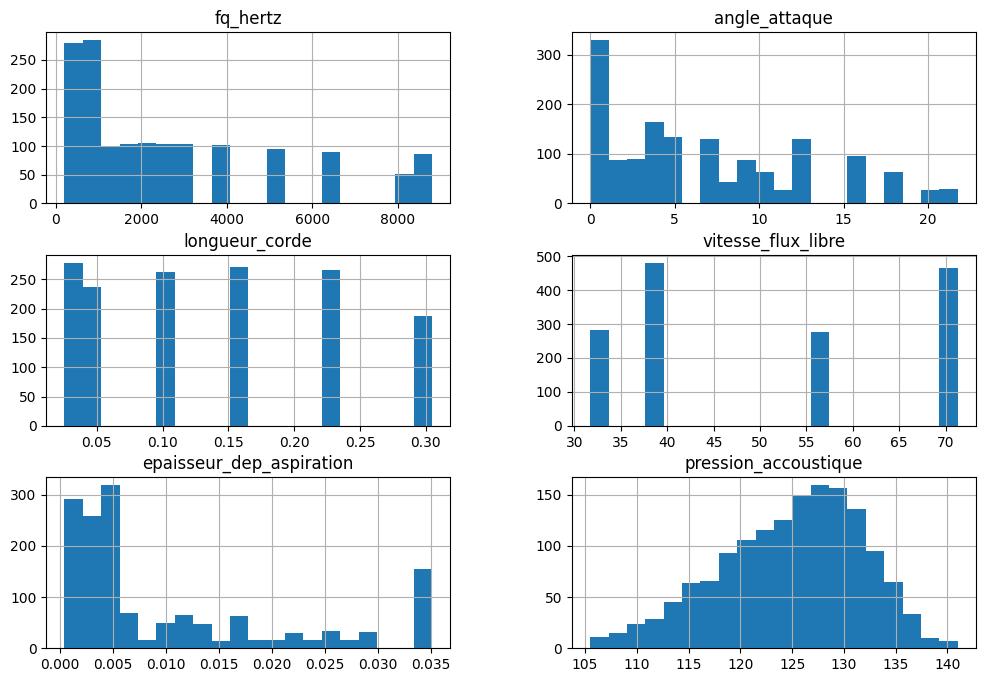

In [8]:
data.hist(bins=20, figsize=(12, 8))
plt.show()

# **Matrice de corrélation**

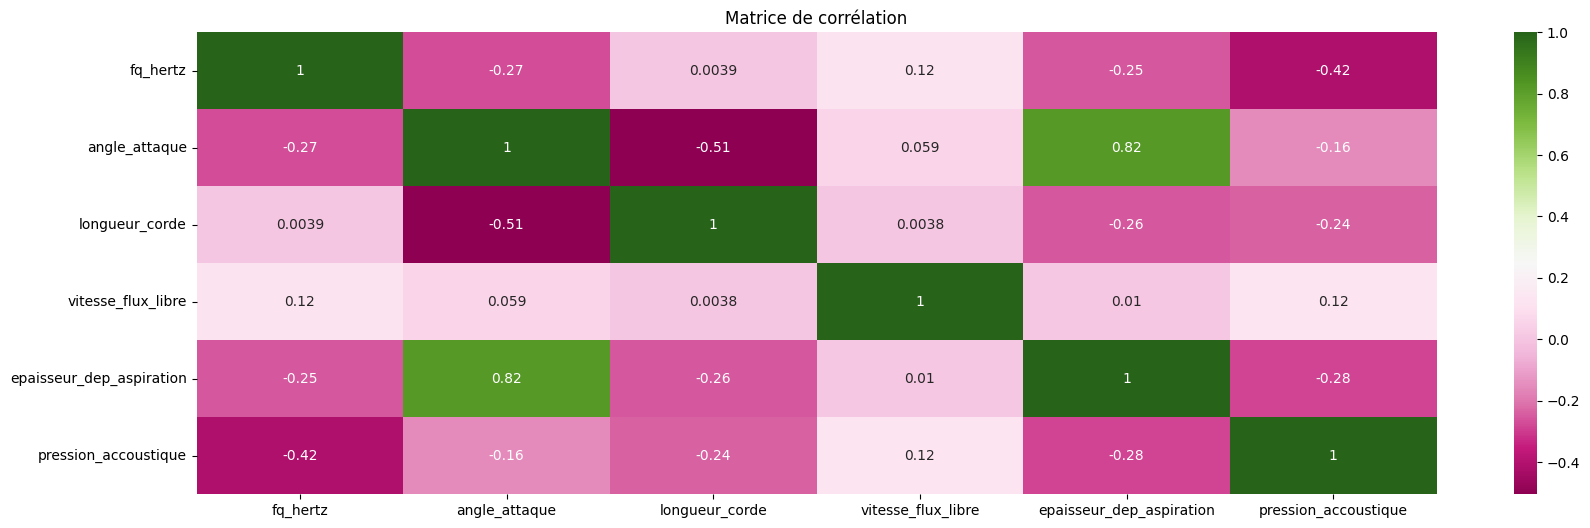

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
fq_hertz,1.0,-0.27428,0.003938,0.117396,-0.25248,-0.416427


In [9]:
# variables
matrice = data.corr()

# graph
plt.figure(figsize=(20, 6))
sns.heatmap(matrice, annot=True, cmap='PiYG')
plt.title('Matrice de corrélation')
plt.show()

print()
print()

# cible sur la target
display(matrice.head(1))

## Remarques
* -1 < valeurs matrice < 1
    - valeur proche de 1 --> corrélation forte
    - valeur proche de 0 --> corrélation faible
    - valeur proche de -1 --> corrélation négative
* valeurs > 0 --> corrélation positive : les deux variables augmentent ou diminuent ensemble
* valeurs < 0 --> corrélation négative : les deux variables augmentent ou diminuent dans des directions opposées
<br>
<br>

On remarque principalement que :
* il y a une corrélation positive entre l'angle d'attaque et l'épaisseur du déplacement coté aspiration
* il y a une corrélation négative entre l'angle d'attaque et la longueur de la corde
* il y a une corrélation négative entre la pression accoustique et la fréquence

# **=====================================================================================================IA=====================================================================================================**

# **Preprossessing of data**

In [9]:
target = data['pression_accoustique']
preprocessed_data = data.drop(columns=[f'{target.name}']) # on enlève la variable cible

scaler = StandardScaler()

n_components = 2

# **PCA (Analyse en Composition Principales)**

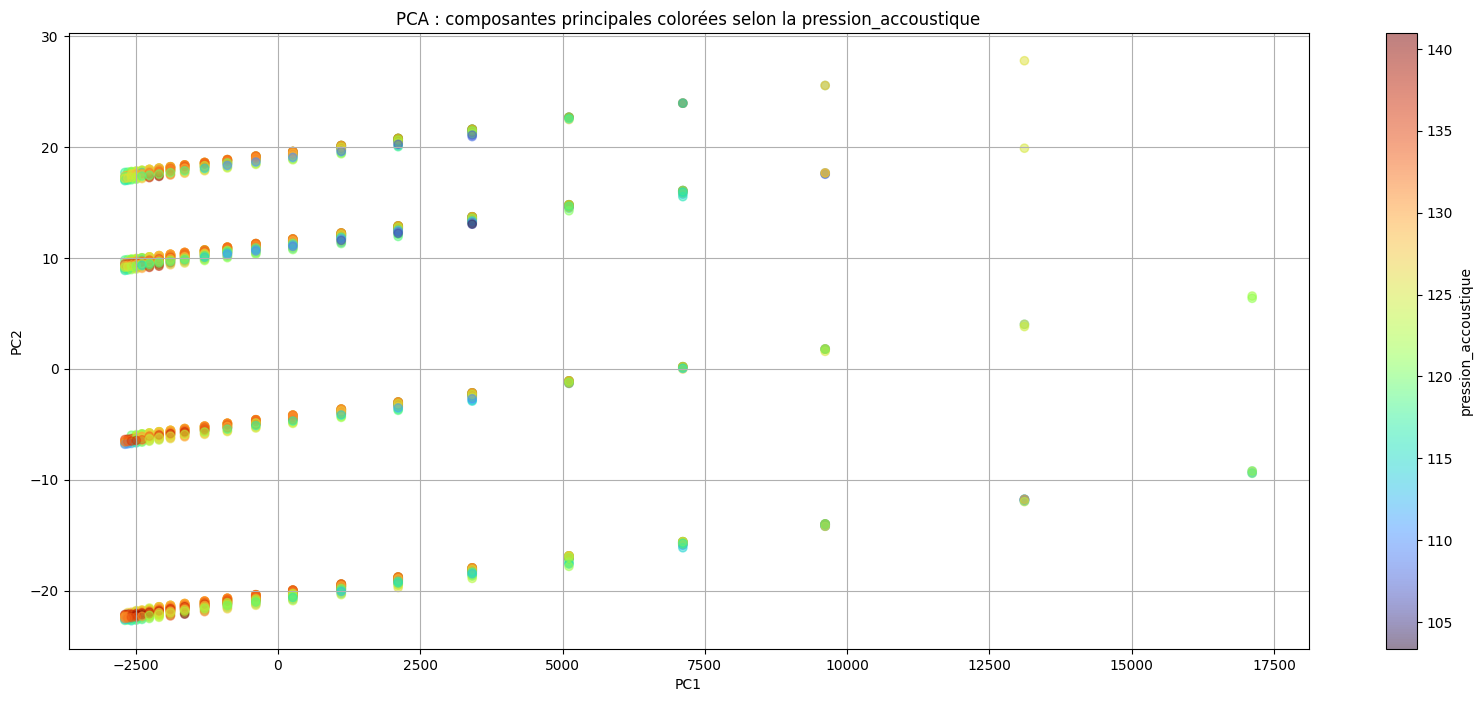

In [33]:
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(preprocessed_data)
principal_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
plt.figure(figsize=(20, 8))
plt.scatter(principal_df["PC1"], principal_df["PC2"], c=target, cmap='turbo', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA : composantes principales colorées selon la {target.name}")
plt.colorbar(label=f'{target.name}')
plt.grid()
plt.show()

In [ ]:
# Obtenir les valeurs propres
eigenvalues = pca.explained_variance_ratio_

print("{:<15} {:<2.6f} {:<15} {:<2.6f}".format("Valeurs propres PC1 :", eigenvalues[0], "Valeurs propres PC2 :", eigenvalues[1]))

Valeurs propres PC1 : 0.999957 Valeurs propres PC2 : 0.000038


## Remarques
PC1 et PC2 sont des combinaisons linéaires de des variables d'origine qui permettent de représenter les données d'une manière qui maximise la variance
<br>
--> But : réduire la dimensionnalité des données tout en préservant un maximum d'informations
<br>
<br>
**Observations :** Les données semblent être linéaires avec une variance élevée. PC1 est la composante qui explique le plus de variance : sa valeur propre (mesure de la variance de la composante) est de 99,9957% contre 0,0038% pour PC2.



# **TSNE (t-distributed stochastic neighbor embedding)**

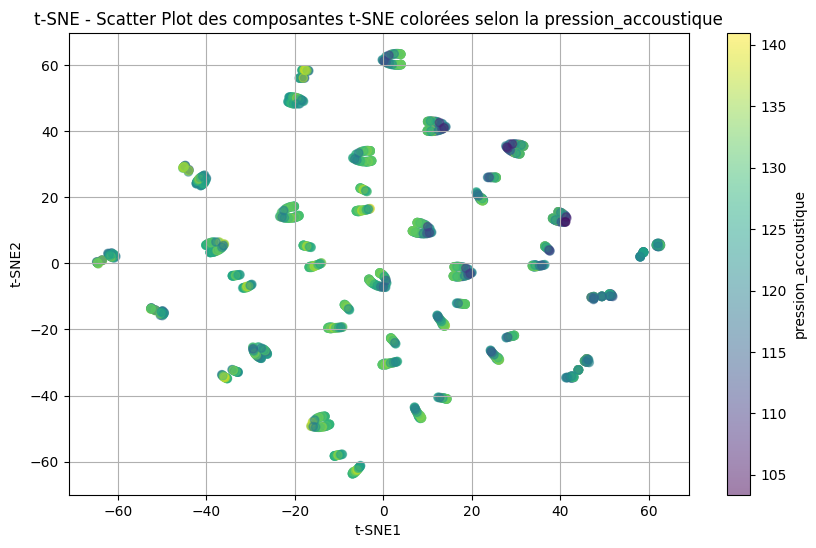

In [34]:
tsne = TSNE(n_components=n_components, perplexity=25, random_state=42)
tsne_components = tsne.fit_transform(preprocessed_data)

tsne_df = pd.DataFrame(data=tsne_components, columns=["t-SNE1", "t-SNE2"])

# graph
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df["t-SNE1"], tsne_df["t-SNE2"], c=target, alpha=0.5)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title(f"t-SNE - Scatter Plot des composantes t-SNE colorées selon la {target.name}")
plt.colorbar(label=f'{target.name}')
plt.grid()
plt.show()

## Remarques
* Les données regroupées indiquent des regroupements dans les données
* Les points éloignés peuvent être considérés comme des valeurs aberrantes

# **Self-Organizing Maps (SOM) ~~ cartes auto-organisatrices**

1. **Définition**
* Algorithme d’apprentissage non supervisé (pas de variable cible)
* Algorithme de classification (clustering) qui généralise l’algorithme d’apprentissage compétitif en rajoutant une structure de voisinage entre les classes
* Complexité : linéaire par rapport au nombre de données --> facile à programmer
* Réduire la dimensionnalité des données tout en conservant les structures et les relations entre les données --> facilite l'exploration des données
<br>
<br>
2. **Fonctionnement**
* Les cartes auto-organisatrices de **Kohonen** (1984) sont constituées d'une grille. Dans chaque nœud de la grille se trouve un « neurone »
* Chaque neurone est associé à un vecteur de poids initialisé aléatoirement.
* Chaque neurone calcule sa similarité avec les données d'entrée (mesures telles que la distance euclidienne)
* **Neurone gagnant** = neurone dont le vecteur de poids est le plus similaire aux données
* Les vecteurs de poids des neurones voisins du neurone gagnant sont ajustés pour devenir plus similaires aux données d'entrée --> forme des groupes / clusters
<br>
<br>
Les paramètres de SOM sont les suivants :
* x : som_grid_rows, est le nombre de lignes
* y : som_grid_columns, est le nombre de colonnes
* Sigma est le rayon du voisinage
* learning_rate
<br>
<br>
Utilisées pour visualiser des données telles que des images, des séquences temporelles ou des caractéristiques complexes.

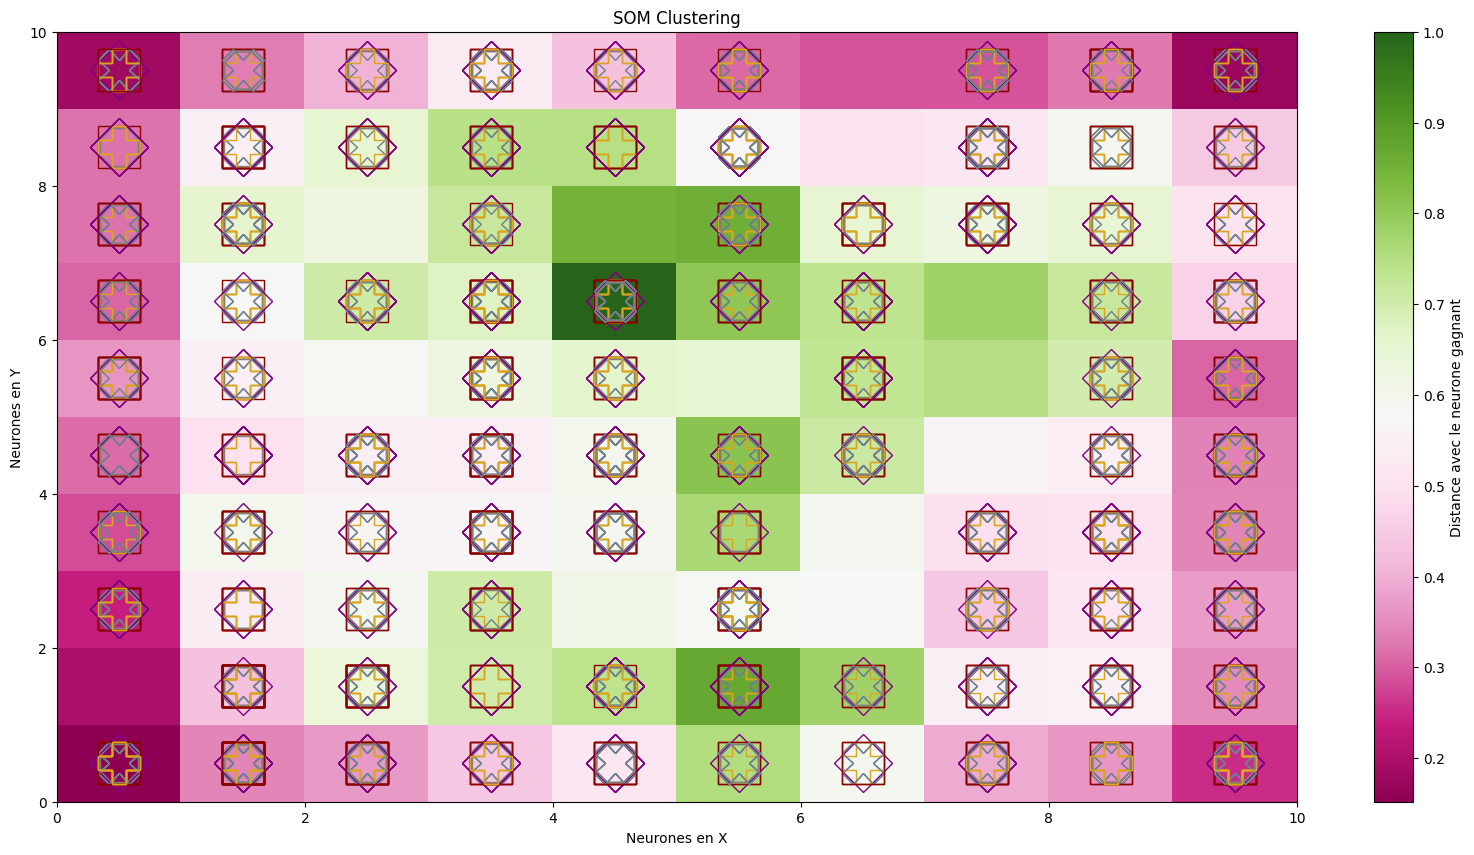

In [35]:
# Mise à l’échelle des x variables
min_max_scaler = MinMaxScaler() # utilisation de MinMaxScaler pour redimensionner les valeurs dans un interval de 0, 1 utile car tout dépend des distances
x = min_max_scaler.fit_transform(preprocessed_data)
pd.DataFrame(x)

som_dimens = (10, 10)
iterations = 20000
sigma = 1
learning_rate = 0.5

som = MiniSom(x = som_dimens[0],
              y = som_dimens[1],
              input_len = 5,
              sigma = sigma,
              learning_rate = learning_rate)

som.random_weights_init(x)

som.train_random(x, iterations)

# ==============================================================================

plt.figure(figsize=(20, 10))
plt.pcolor(som.distance_map().T, cmap='PiYG')
plt.colorbar(label="Distance avec le neurone gagnant")

colors = ['darkred', 'gray', 'purple', 'goldenrod', 'slategrey']
markers = ['s', '8', 'D', 'P', 'X']

for i, x in enumerate(x):
  index = int(target[i] % len(markers))
  winner = som.winner(x)
  plt.plot(winner[0] + 0.5,
           winner[1] + 0.5,
           markers[index],
           markeredgecolor = colors[index],
           markerfacecolor = 'None',
           markersize = 30)

plt.title('SOM Clustering')
plt.xlabel('Neurones en X')
plt.ylabel('Neurones en Y')
plt.show()

## Remarques
Les neurones représentent des clusters de données similaires :
<br>
* La majorité des noeuds ont des valeurs proches du neurone gagnant (couleur rose) --> les données sont rapprochées et se regroupent naturellement.
* Le noeud gagant est celui dont la valeur est minimale (couleur rose foncé) --> son vecteur de poids est le plus similaires aux données d'entrée.
<br>
Il représente le regroupement auquel les données d'entrée spécifiques sont les plus similaires.
<br>
<br>
* Les marqueurs sont utilisés pour indiquer à quelle catégorie chaque neurone est asocié après l'apprentissage de la carte.

# **=======================================================================================Supervised_Machine_Learning_Tasks=======================================================================================**

# **Mise à l'échelle des données**

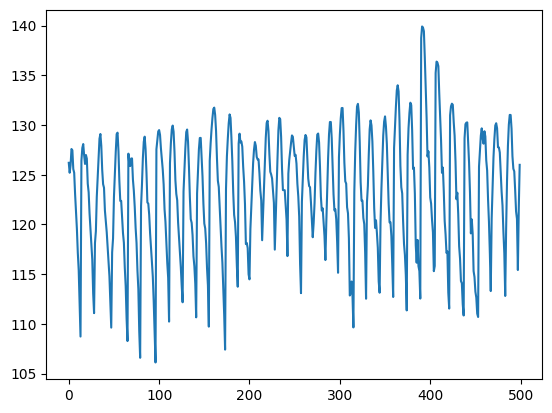

In [24]:
SEED = 1

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, target, test_size = 0.2, random_state = SEED)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.plot(target[:500])

# **Modèles individuels**

Tous sont des algorithmes d'apprentissage supervisé ou modèles individuels.
<br>
<br>

## **Random Forest**
Repose sur des arbres (arbres de décision)

**Fonctionnement :**
* Découpage du dataset en plusieurs sous-ensemble
* Entrainement d'un modèle sur chaque souis-ensemble
* Regroupement de tous les résultats du modèle
<br>
<br>

## **Extra Trees (Extra Trees Regressor)**
Similaire aux arbres de décision, mais avec une touche d'aléatoire

**Fonctionnement :**
* Découpe le dataset en plusieurs sous-ensembles
* Pour chaque sous-ensemble, il crée un arbre de décision avec des règles aléatoires pour réduire le surajustement
* Les résultats de tous les arbres sont combinés pour produire la prédiction finale
<br>
<br>

## **Decision Tree (Decision Tree Regressor)**
Crée un arbre de décision pour la prise de décision

**Fonctionnement :**
* Divise le dataset en fonction des caractéristiques, en essayant de minimiser l'impureté des nœuds
* L'arbre est utilisé pour prendre des décisions en suivant les chemins du haut vers le bas
* Peut être sensible au surajustement (overfitting) s'il est trop profond
<br>
<br>

## **XGBoost (XGBoost Regressor)**

* Algorithme spécialement conçu pour la régression et la classification
* Utilise un ensemble de modèles d'arbres de décision faibles (weak learners)

**Fonctionnement :**
* Les modèles sont formés de manière séquentielle, en corrigeant les erreurs des modèles précédents
* Utilise des techniques de régularisation pour éviter le surajustement
* Donne des performances élevées dans de nombreuses tâches d'apprentissage automatique
<br>
<br>

## **CatBoost (CatBoost Regressor)**
* Algorithme adapté aux données catégorielles
* Gère automatiquement les données catégorielles sans conversion en données numériques
* Utilise un grand nombre d'arbres de décision pour la prédiction
* Utilise un algorithme de gradient pour minimiser la perte
* Est conçu pour être efficace et précis, avec des paramètres par défaut bien ajustés
<br>
<br>

## **LightGBM (LightGBM Regressor)**

* Algorithme conçu pour être rapide et précis
* Utilise un algorithme de gradient pour l'entraînement des arbres
* Utilise une stratégie de division en feuille (Leaf-Wise) pour accélérer la convergence
* Peut gérer des datasets volumineux et dispose d'options de parallélisme
* Dispose de paramètres ajustables pour optimiser les performances en fonction des besoins


In [18]:
results_models = []

In [19]:
from sklearn.metrics import d2_absolute_error_score as d2_score
def calculateModelsWithDifferentsMetrics(models, X_train, X_test, y_train, y_test):
    measures = [d2_score, MAE, MSE, r2_score, 'RMSE']

    results = []

    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_results = [model_name]

        for measure in measures:
          if measure == 'RMSE':
            result = np.sqrt(MSE(y_test, y_pred))
            model_results.append(result)
          else :
            result = measure(y_test, y_pred)
            model_results.append(result)

        results.append(model_results)
    return results

In [25]:
def graphPerformanceModels(results):
    model_names = [row[0] for row in results]
    d2_values = [row[1] for row in results]
    mae_values = [row[2] for row in results]
    mse_values = [row[3] for row in results]
    r2_values = [row[4] for row in results]
    rmse_values = [row[5] for row in results]

    bar_width = 0.2
    index = np.arange(len(model_names))

    plt.figure(figsize=(12, 4))
    plt.bar(index, d2_values, bar_width, label='D2')
    plt.bar(index + bar_width, mae_values, bar_width, label='MAE')
    plt.bar(index + 2 * bar_width, mse_values, bar_width, label='MSE')
    plt.bar(index + 3 * bar_width, r2_values, bar_width, label='R2')
    plt.bar(index + 4 * bar_width, rmse_values, bar_width, label='RMSE')

    plt.xlabel('Modèle')
    plt.ylabel('Valeurs')
    plt.title('Performances des modèles')
    plt.legend()
    plt.xticks(index + 1.5 * bar_width, model_names, rotation=45)

    plt.show()

In [20]:
def affichePerformanceModels(results):
    print("{:<15} \t {:<10} \t {:<10} \t {:<10} \t {:<10} \t {:<10}".format("Techniques", "D2", "MAE", "MSE", "R2", "RMSE"))
    print("______________________________________________________________________________________________")
    for row in results:
        print("{:<15} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f}".format(*row))
        print("______________________________________________________________________________________________")

In [12]:
models_individuels = [
  ("Random Forest", RandomForestRegressor(random_state = SEED)),
  ("Extra Trees", ExtraTreesRegressor(random_state = SEED)),
  ("Decision Tree", DecisionTreeRegressor(random_state = SEED)),
  ("XGBoost", XGBRegressor(random_state = SEED)),
  ("CatBoost", CatBoostRegressor(random_seed = SEED)),
  ("LightGBM", LGBMRegressor(random_state = SEED))
]

In [ ]:
results_models = calculateModelsWithDifferentsMetrics(models_individuels, X_train, X_test, y_train, y_test)

In [ ]:
affichePerformanceModels(results_models)
graphPerformanceModels(results_models)

* **MSE** (Mean Squared Error) - Erreur quadratique moyenne. Doit être proche de 0 : prédictions du modèle sont très proches des valeurs réelles
<br>
<br>
* **MAE** (Mean Absolute Error) - Erreur absolue moyenne. Doit être proche de 0 : les écart entre les prédictions et les valeurs réelles sont très faibles
<br>
<br>
* **RMSE** (Root Mean Squared Error) - Erreur quadratique moyenne de la racine carrée. Doit être proche de 0 : même principe, une valeur proche de 0 indique un taux d'erreur dans les prédictions très faible
<br>
<br>
* **R-squared** (R²) - Coefficient de détermination : proportion de la variance dans la variable cible. Doit être proche de 1 : le modèle explique parfaitement la variance des données

## Remarques
Le meilleur modèle est Extra Trees : les valeurs pour MAE, MSE, RMSE sont proche de 0 tandis que la valeur pour R2 est la plus proche de 1.
<br>
Cela signifie que le modèle explique parfaitement la variance des données tandis que le taux d'erreur commise est très faible.

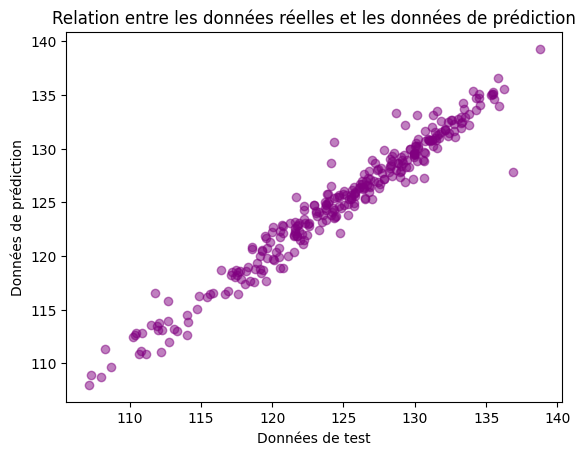

In [31]:
extra_trees_model = ExtraTreesRegressor(random_state = SEED)
extra_trees_model.fit(X_train, y_train)
# y_train = extra_trees_model.predict(X_test)

plt.scatter(y_test, extra_trees_model.predict(X_test), color='purple', alpha = 0.5)
plt.xlabel(xlabel='Données de test')
plt.ylabel(ylabel='Données de prédiction')
plt.title(label='Relation entre les données réelles et les données de prédiction')
plt.show()

## Remarques
* Les données de prédictions et les données originelles forment une ligne avec quelque points en dehors
* On en déduit que les valeurs de prédiction sont presques similaires à celles d'origine

# **Ajustement des hyparamètres du modèle individuel**

* Trouver les meilleurs valeurs pour les paramètres de configuration (complexité du modèle, capacité de généralisation, taux d'apprentissage, nombre d'itération, ...)
* Permet d'améliorer les performances du modèle
<br>
<br>

### **Recherche en grille (Grid Search) :**

* La recherche en grille consiste à spécifier une liste de valeurs pour chaque hyperparamètre que vous souhaitez ajuster.
* Elle examine toutes les combinaisons possibles de ces valeurs.
* Cela signifie que la recherche en grille peut être très coûteuse en termes de temps de calcul, en particulier si vous avez de nombreux hyperparamètres et un grand nombre de valeurs à tester.
* Elle garantit de trouver les meilleurs hyperparamètres, mais cela peut prendre beaucoup de temps.
<br>

### **Recherche aléatoire (Random Search) :**

* La recherche aléatoire consiste à spécifier une distribution de probabilité pour chaque hyperparamètre, plutôt que des valeurs spécifiques.
* Elle échantillonne aléatoirement les hyperparamètres dans ces distributions.
* Par conséquent, la recherche aléatoire explore un espace d'hyperparamètres plus large en moins de temps que la recherche en grille.
* Cependant, il n'est pas garanti de trouver les meilleurs hyperparamètres, car certains jeux d'hyperparamètres peuvent ne jamais être échantillonnés.
<br>

### **Optimisation bayésienne :**

* L'optimisation bayésienne est une méthode plus sophistiquée qui utilise des modèles probabilistes pour estimer les performances du modèle en fonction des hyperparamètres.
* Elle utilise ces estimations pour décider quelles valeurs d'hyperparamètres explorer ensuite.
* L'optimisation bayésienne est plus efficace que la recherche en grille et la recherche aléatoire, car elle tient compte des informations accumulées au fil des itérations pour cibler les hyperparamètres les plus prometteurs.
* Elle est particulièrement utile lorsque l'ajustement des hyperparamètres est coûteux en temps, car elle nécessite moins d'expérimentations.

In [44]:
def hyperparametersTuning(models, X_train, X_test, y_train, y_test):

  hyperparameters_results = []

  techniques = []

  for model_name, model, params in models:
    techniques.append((model_name, model, 'GridSearchCV', GridSearchCV(model, params, scoring='neg_mean_squared_error'))),
    techniques.append((model_name, model, 'RandomizedSearchCV', RandomizedSearchCV(model, params, n_iter=10, scoring='neg_mean_squared_error', random_state=SEED))),
    techniques.append((model_name, model, 'BayesSearchCV', BayesSearchCV(model, params, n_iter=10, scoring='neg_mean_squared_error', random_state=SEED)))

  for model_name, model, technique_name, technique in techniques:
    technique.fit(X_train, y_train)
    best_params = technique.best_params_
    print(f'{technique_name} meilleurs hyperparamètres pour {model_name} : {best_params}')

    # Modèle ajusté avec les hyperparamètres
    model_tuned = model.set_params(**best_params)
    model_tuned.fit(X_train, y_train)
    y_pred_tuned = model_tuned.predict(X_test)
    # Calcul des métriques pour les modèles
    mae_tuned = MAE(y_test, y_pred_tuned)
    mse_tuned = MSE(y_test, y_pred_tuned)
    r2_tuned = r2_score(y_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mse_tuned)

    hyperparameters_results.append([technique_name, mae_tuned, mse_tuned, r2_tuned, rmse_tuned])

  return hyperparameters_results

In [82]:
params = {
  'n_estimators': [100, 150, 200, 250, 300],
  'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
  'max_depth': [5, 10, 15],
}
model = [
  # ("Random Forest", RandomForestRegressor(random_state = SEED), params),
  ("Extra Trees", ExtraTreesRegressor(random_state = SEED), params)
]

extra_trees_hyperparams_results = hyperparametersTuning(model, X_train, X_test, y_train, y_test)
print()
print()
affichePerformanceModels(extra_trees_hyperparams_results)

GridSearchCV meilleurs hyperparamètres pour Extra Trees : {'criterion': 'friedman_mse', 'max_depth': 15, 'n_estimators': 300}
RandomizedSearchCV meilleurs hyperparamètres pour Extra Trees : {'n_estimators': 300, 'max_depth': 15, 'criterion': 'friedman_mse'}
BayesSearchCV meilleurs hyperparamètres pour Extra Trees : OrderedDict([('criterion', 'absolute_error'), ('max_depth', 10), ('n_estimators', 250)])


Techniques      	 MAE        	 MSE        	 R2         	 RMSE      
___________________________________________________________________________________
GridSearchCV    	 0.952      	 1.763      	 0.958      	 1.328     
___________________________________________________________________________________
RandomizedSearchCV 	 0.952      	 1.763      	 0.958      	 1.328     
___________________________________________________________________________________
BayesSearchCV   	 1.515      	 3.868      	 0.909      	 1.967     
_________________________________________________________________

## Remarques
L'ajustement des hyperparamètres ne change pas significativement les résultats du modèle Extra Trees (légère diminution, égalité ou légère augmentation).

# **Modèles d'ensemble**

## **Bagging**
<br>
Bagging : Boostrap aggregating
<br>

* Utilise une technique connue sous le nom de Bootstrap

* Réduit la variance des modèles individuels dans l'ensemble
<br>
<br>

## **Staking**
<br>
<br>

## **Voting**
Voting : Méthode d'ensemble utilisée en apprentissage automatique pour combiner les prédictions de plusieurs modèles de maching learning différents
<br>

* **Hard Voting**
* Chaque modèle vote pour sa classe de prédiction, la classe avec le nombre maximal de vote et choisie comme prédiction finale
<br>
<br>
* **Soft Voting**
* Au lieu de voter pour des classes discrètes, les modèles produisent des scores de probabilité pour chaque classe.
* Le soft voting calcule la moyenne des scores de probabilité de chaque classe à partir de tous les modèles, puis sélectionne la classe avec la probabilité la plus élevée comme prédiction finale.
* Cette approche est souvent plus précise que le vote dur car elle prend en compte l'incertitude des modèles.

In [16]:
best_params_extra_trees = {
  'n_estimators': 300,
  'criterion': 'friedman_mse',
  'max_depth': 15,
}

extra_trees_model = ExtraTreesRegressor(random_state = SEED)
extra_trees_tuned = ExtraTreesRegressor(random_state = SEED, **best_params_extra_trees)
results_techniques = []

In [17]:
models_ensemble = [
    ("BaggingRegressor", BaggingRegressor(estimator = extra_trees_model)),
    ("B.R hyperparamètres", BaggingRegressor(estimator = extra_trees_tuned)),

    ("StackingRegressor", StackingRegressor([('extra_trees_model', extra_trees_model)])),
    ("S.R hyperparamètres", StackingRegressor(estimators = [('extra_trees_tuned', extra_trees_tuned)])),

    ("VotingRegressor", VotingRegressor([('extra_trees_model', extra_trees_model)])),
    ("V.R hyperparamètres", VotingRegressor(estimators = [('extra_trees_tuned', extra_trees_tuned)]))
]

# ("StackingRegressor", StackingRegressor([('extra_trees_model', extra_trees_model), ('catboost', catboost_model)])),
# ("VotingRegressor", VotingRegressor([('extra_trees_model', extra_trees_model), ('catboost', catboost_model)])),

Techniques      	 D2         	 MAE        	 MSE        	 R2         	 RMSE      
______________________________________________________________________________________________
BaggingRegressor 	 0.776      	 1.175      	 2.546      	 0.940      	 1.596     
______________________________________________________________________________________________
B.R hyperparamètres 	 0.773      	 1.192      	 2.528      	 0.940      	 1.590     
______________________________________________________________________________________________
StackingRegressor 	 0.826      	 0.913      	 1.749      	 0.959      	 1.323     
______________________________________________________________________________________________
S.R hyperparamètres 	 0.825      	 0.917      	 1.680      	 0.960      	 1.296     
______________________________________________________________________________________________
VotingRegressor 	 0.818      	 0.953      	 1.849      	 0.956      	 1.360     
____________________________

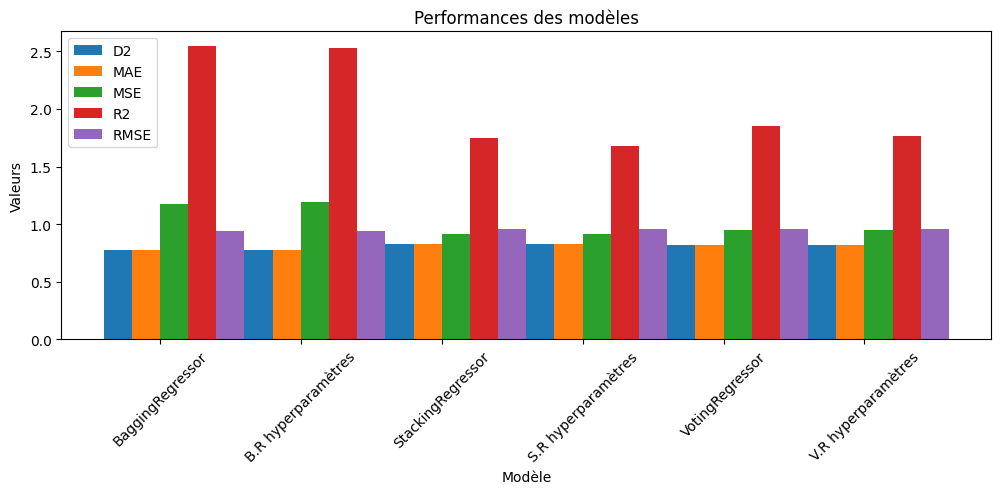

In [163]:
results_techniques = calculateModelsWithDifferentsMetrics(models_ensemble, X_train, X_test, y_train, y_test)

affichePerformanceModels(results_techniques)
graphPerformanceModels(results_techniques)

## Remarque

On constate que StackingRegressor avec un ExtraTreesRegressor ajusté avec des hyperparamètres donne de meilleurs résultats.
<br>
<br>
Les résultats montrent que StackingRegressor obtient de meilleures performances lorsqu'il prend en paramètre un ExtraTreesRegressor préalablement ajusté avec des hyperparamètres optimisés.

# **Score d'importance**

* Évaluer l'influence de chaque variable
* Ces scores mesurent à quel point chaque variable contribue à la performance globale du modèle
<br>
<br>

### **Modèles individuels**
<br>
Les scores donnent une idée de la contribution de chaque caractéristiques à la prédiction du modèle
<br>

**Gini Importance**
* « diminution moyenne de l’impureté »
* Définie comme la diminution totale de l’impureté du nœud qui est pondérée par la probabilité d’atteindre ce nœud
* Méthode moyennée sur tous les arbres de l’ensemble
<br>
<br>

**Modèles d'ensemble**
<br>
Les scores donnent une idée de la contribution relative de chaque caractéristique à la performance globale de l'ensemble

In [10]:
def calculateImportanceIndividualModels(models, preprocessed_data, X_train, y_train):

    feature_importances = [0] * len(preprocessed_data.columns)
    feature_names = preprocessed_data.columns

    for model_name, model in models:
        model.fit(X_train, y_train)

        for index, importance in enumerate(model.feature_importances_):
            feature_importances[index] += importance

    total_importance = sum(feature_importances)
    normalized_importances = [importance / total_importance for importance in feature_importances]

    return [normalized_importances, feature_names]

## Remarque
Calcul des scores d'importance des modèles d'ensemble en utilisant la technique de permutation

In [47]:
def calculateImportanceEnsembleModels(models, X_train, X_test, y_train, y_test, metric=MAE, num_permutations=20):

    feature_importances = [0] * len(preprocessed_data.columns)
    feature_names = preprocessed_data.columns

    for model_name, model in models:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        baseline_score = metric(y_test, y_pred)

        for feature in range(len(feature_names)):
            permuted_scores = []

            for _ in range(num_permutations):
                X_permuted = X_test.copy()
                X_permuted[:, feature] = np.random.permutation(X_permuted[:, feature])
                y_pred = model.predict(X_permuted)
                permuted_score = metric(y_test, y_pred)
                permuted_scores.append(permuted_score)

            feature_importances[feature] += baseline_score - np.mean(permuted_scores)
    total_importance = sum(feature_importances)
    normalized_importances = [importance / total_importance for importance in feature_importances]

    return [normalized_importances, feature_names]

In [12]:
def afficheImportanceCaracteristiques(feature_importances, feature_names):
    palette = ['red', 'steelblue', 'seagreen', 'mediumorchid', 'pink']

    plt.figure(figsize=(20, 6))
    plt.title("Importance des caractéristiques")
    plt.barh(range(len(feature_importances)), [importance for importance in feature_importances], align="center", color=palette)
    plt.yticks(range(len(feature_importances)), [name for name in feature_names])
    plt.tight_layout()
    plt.show()

In [ ]:
importance_models_individuels = calculateImportanceIndividualModels(models_individuels, preprocessed_data, X_train, y_train)

In [48]:
importance_models_ensemble = calculateImportanceEnsembleModels(models_ensemble, X_train, X_test, y_train, y_test)

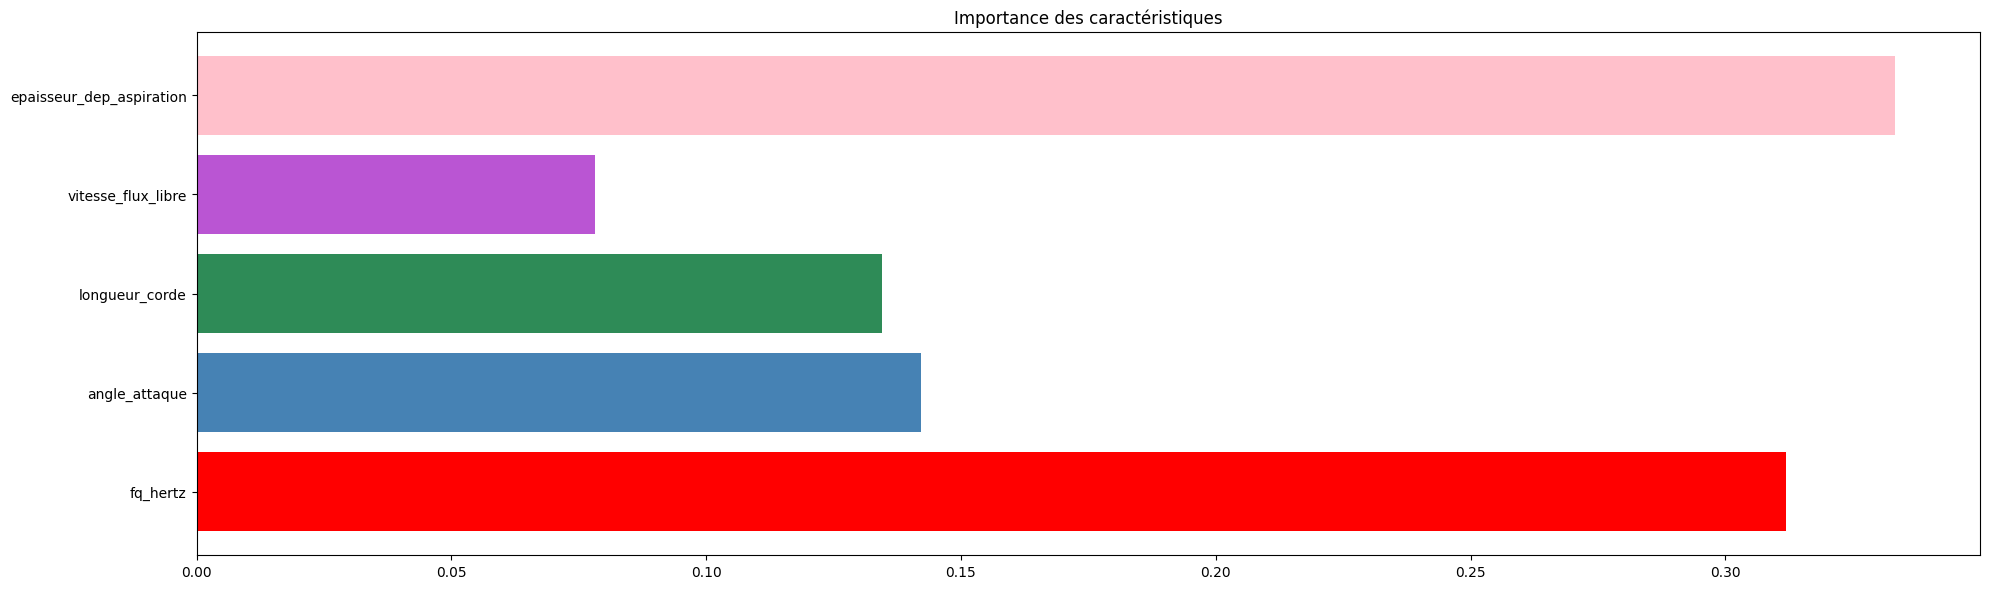

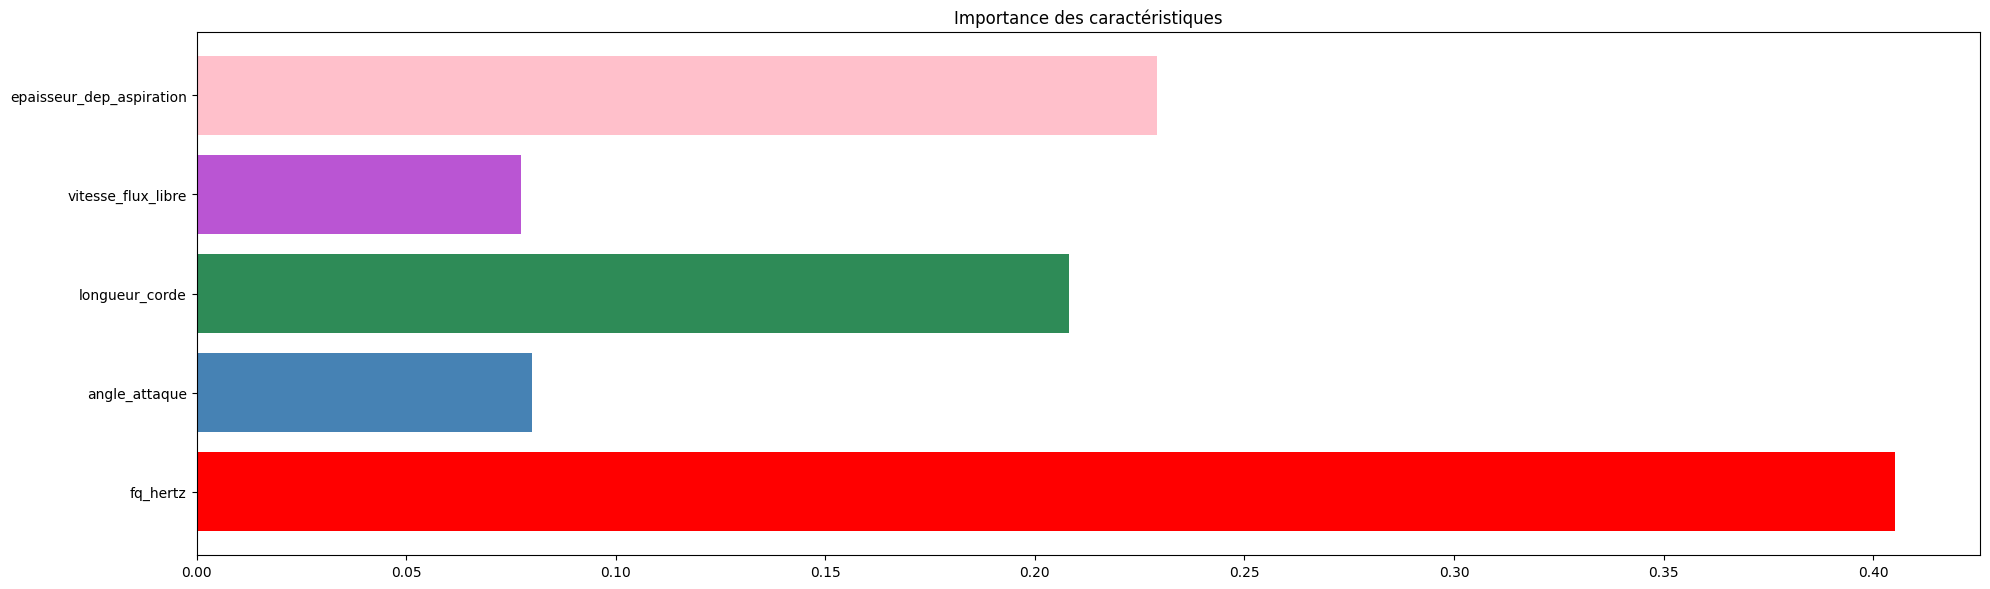

In [53]:
afficheImportanceCaracteristiques(importance_models_individuels[0], importance_models_individuels[1])
afficheImportanceCaracteristiques(importance_models_ensemble[0], importance_models_ensemble[1])

# **Explication des décisions prises par les modèles**

In [37]:
def calculateShapValues(models, X_train, X_test, y_train):

    for model_name, model in models:
        model.fit(X_train, y_train)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        print(model_name)
        shap.summary_plot(shap_values, X_test)

Random Forest


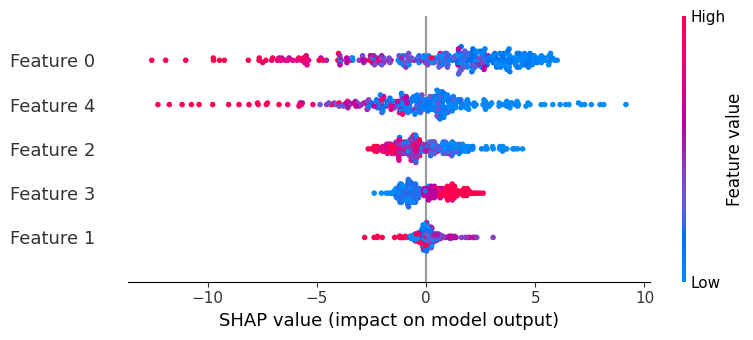

Extra Trees


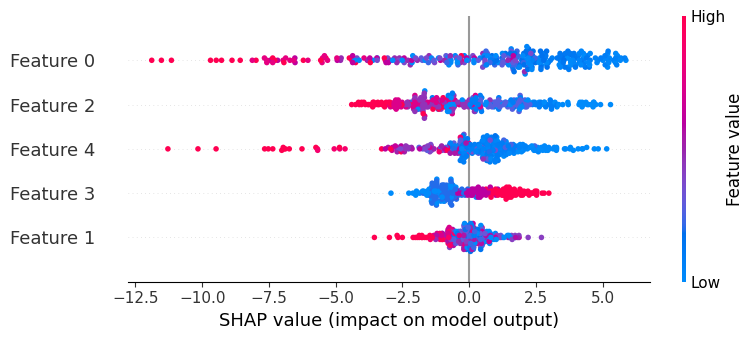

Decision Tree


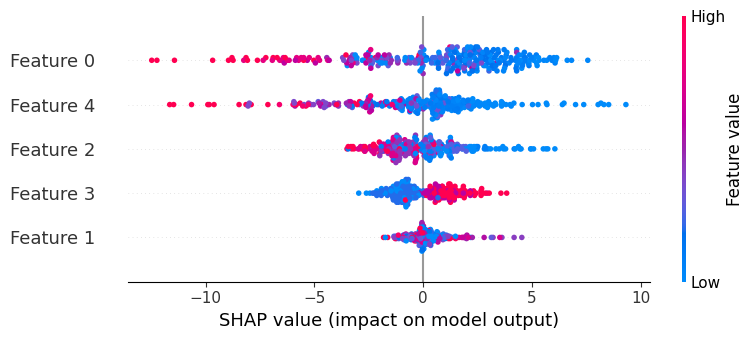

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
[16:25:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


XGBoost


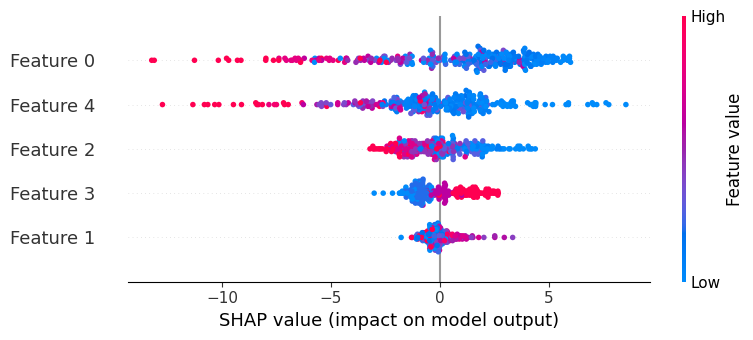

Learning rate set to 0.042151
0:	learn: 6.8467438	total: 852us	remaining: 852ms
1:	learn: 6.7228469	total: 1.51ms	remaining: 753ms
2:	learn: 6.5905768	total: 2.27ms	remaining: 754ms
3:	learn: 6.4514415	total: 2.92ms	remaining: 727ms
4:	learn: 6.3409732	total: 3.58ms	remaining: 713ms
5:	learn: 6.2299488	total: 4.21ms	remaining: 698ms
6:	learn: 6.1334886	total: 4.79ms	remaining: 680ms
7:	learn: 6.0363875	total: 5.39ms	remaining: 668ms
8:	learn: 5.9276038	total: 6ms	remaining: 661ms
9:	learn: 5.8368850	total: 6.55ms	remaining: 649ms
10:	learn: 5.7292829	total: 7.17ms	remaining: 644ms
11:	learn: 5.6131113	total: 7.74ms	remaining: 637ms
12:	learn: 5.5272497	total: 8.32ms	remaining: 632ms
13:	learn: 5.4445097	total: 8.93ms	remaining: 629ms
14:	learn: 5.3481748	total: 9.71ms	remaining: 638ms
15:	learn: 5.2549859	total: 10.4ms	remaining: 641ms
16:	learn: 5.1781390	total: 11ms	remaining: 638ms
17:	learn: 5.0949556	total: 11.7ms	remaining: 636ms
18:	learn: 4.9953325	total: 12.3ms	remaining: 633m

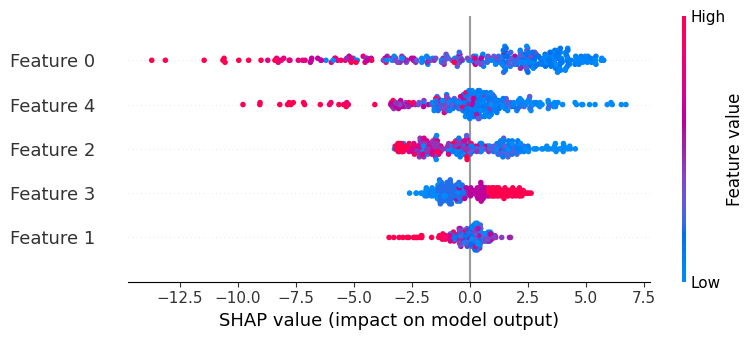

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 1202, number of used features: 5
[LightGBM] [Info] Start training from score 124.852480
LightGBM


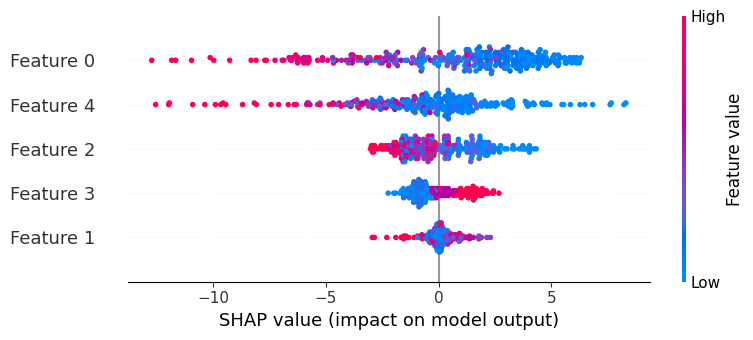

In [38]:
calculateShapValues(models_individuels, X_train, X_test, y_train)